In [ ]:
# Downloading dataset

!wget http://fsoco.cs.uni-freiburg.de/datasets/fsoco_bounding_boxes_train.zip

In [ ]:
# Extracting the dataset

!unzip fsoco_bounding_boxes_train.zip -d fsoco-dataset

In [ ]:
# Converting the dataset to the YOLO format

import json
import os
from pathlib import Path
import random


DATASET_ROOT = "fsoco-dataset"
OUTPUT_BASE = "fsoco-dataset-yolo"

# Split ratios
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Map class names to YOLO class IDs
CLASS_MAP = {
    "blue_cone": 0,
    "yellow_cone": 1,
    "orange_cone": 2,
}

action = "cp" # change to "mv" if you wish to move the files

# Create output directories
for split in ['train', 'val', 'test']:
    Path(os.path.join(OUTPUT_BASE, split, 'images')).mkdir(parents=True, exist_ok=True)
    Path(os.path.join(OUTPUT_BASE, split, 'labels')).mkdir(parents=True, exist_ok=True)

def convert_box(x1, y1, x2, y2, img_w, img_h):
    """Convert XYXY box to YOLO normalized format XYWH."""
    xc = (x1 + x2) / 2.0 / img_w
    yc = (y1 + y2) / 2.0 / img_h
    w  = (x2 - x1) / img_w
    h  = (y2 - y1) / img_h
    return xc, yc, w, h

# Collect all image files
all_files = []
for directory in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, directory)):
        for f in os.listdir(os.path.join(DATASET_ROOT, directory, 'ann')):
            all_files.append((directory, f))

# Shuffle and split
random.shuffle(all_files)
total = len(all_files)
train_count = int(total * TRAIN_RATIO)
val_count = int(total * VAL_RATIO)

train_files = all_files[:train_count]
val_files = all_files[train_count:train_count + val_count]
test_files = all_files[train_count + val_count:]

# Process each split
splits_data = {
    'train': train_files,
    'val': val_files,
    'test': test_files
}

for split_name, files_list in splits_data.items():
    for directory, f in files_list:
        curr = os.path.join(DATASET_ROOT, directory)
        
        json_path = os.path.join(curr, 'ann', f)
        with open(json_path, "r") as J:
            data = json.load(J)
        
        img_w = data["size"]["width"]
        img_h = data["size"]["height"]
        
        # Image filepath is usually the same name but .jpg or .png
        img_name = f.replace(".json", "")
        img_path = os.path.join(curr, 'img', img_name)
        
        if not os.path.exists(img_path):
            img_name = f.replace(".json", ".png")
            img_path = os.path.join(curr, 'img', img_name)
        
        # Skip if image missing
        if not os.path.exists(img_path):
            print(f"Missing image: {img_path}")
            continue
        
        # Copy image to appropriate split
        out_img = os.path.join(OUTPUT_BASE, split_name, 'images', img_name)
        os.system(f"{action} '{img_path}' '{out_img}'")
        
        # Create YOLO label file in appropriate split
        label_file = os.path.join(OUTPUT_BASE, split_name, 'labels', img_name.replace(".jpg", ".txt").replace(".png", ".txt"))
        
        with open(label_file, "w") as LF:
            for obj in data["objects"]:
                cls = obj["classTitle"]
                if cls not in CLASS_MAP:
                    continue  # skip unknown classes
                
                class_id = CLASS_MAP[cls]
                
                # Box coordinates
                (x1, y1), (x2, y2) = obj["points"]["exterior"]
                xc, yc, w, h = convert_box(x1, y1, x2, y2, img_w, img_h)
                
                LF.write(f"{class_id} {xc} {yc} {w} {h}\n")

print(f"Conversion complete.")
print(f"Train: {len(train_files)} images")
print(f"Val: {len(val_files)} images")
print(f"Test: {len(test_files)} images")

# Generate yaml file
with open("dataset.yaml", "w") as df:
    df.write(f"path: {OUTPUT_BASE}\n")
    df.write("train: train/images\n")
    df.write("val: val/images\n")
    df.write("test: test/images\n")
    df.write(f"nc: {len(CLASS_MAP)}\n")
    df.write("names: [")
    df.write(", ".join([f'"{k}"' for k in CLASS_MAP.keys()]))
    df.write("]\n")


In [ ]:
# Training the YOLO model

from ultralytics import YOLO

model = YOLO("yolo11n.pt")

model.train(data="dataset.yaml",
            epochs=100,
            imgsz=640,
            batch=16,
            device="0",
            name="fsoco_yolo11n")


image 1/1 /home/ash/Documents/yolo/fsoco-dataset/amz/img/amz_00024.jpg: 512x640 12 blue_cones, 13 yellow_cones, 1 orange_cone, 4.9ms
Speed: 4.1ms preprocess, 4.9ms inference, 4.5ms postprocess per image at shape (1, 3, 512, 640)
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'blue_cone', 1: 'yellow_cone', 2: 'orange_cone'}
obb: None
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
       

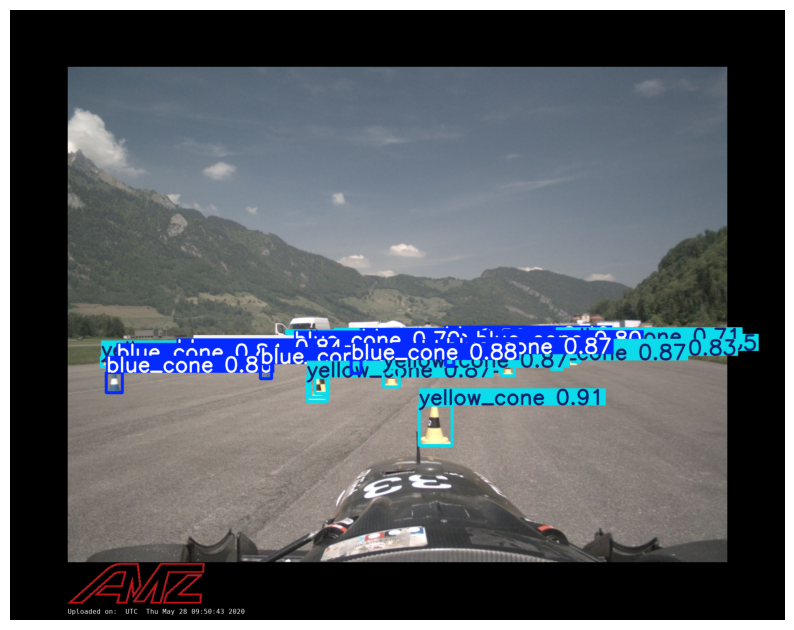

In [ ]:
# Inference
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2


model = YOLO("/home/ash/Documents/yolo-test/runs/detect/fsoco_yolo11n/weights/best.pt")

results = model("/home/ash/Documents/yolo/fsoco-dataset/amz/img/amz_00024.jpg")

# Visualize automatically
annotated = cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB)  # draws boxes

plt.figure(figsize=(10, 10))
plt.imshow(annotated)
plt.axis('off')
plt.show()
